In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json
from cryptocompy import coin,price
import tqdm
import seaborn as sns
sns.set();

import io
import requests
import json
from datetime import datetime
import time
from time import gmtime, strftime

from sklearn import metrics
from fbprophet import Prophet
plt.rcParams["figure.figsize"] = [14,8]
pd.set_option('float_format', '{:f}'.format)

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import datetime
from datetime import datetime as dt
from datetime import timedelta

In [2]:
from tqdm import tqdm_notebook
from livelossplot.keras import PlotLossesCallback


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
#from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool, cv
import catboost
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
#from sklearn.cross_validation import cross_val_score
#from sklearn.grid_search import GridSearchCV
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [3]:
from keras import optimizers
from keras import backend as K

adam = optimizers.Adam(lr=0.01, clipnorm=1.)

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
def my_r2_score(v_true, v_pred):
    ssres = np.sum(np.square(v_true - v_pred))
    sstot = np.sum(np.square(v_true - np.mean(v_true)))
    return 1 - ssres / sstot

In [4]:
def smoothing(val, alpha):
    temp = []
    temp.append(val[0])
    for i in range(1,len(val)):
        temp.append(alpha * val[i] + (1 - alpha) * temp[-1])
    return temp

def get_target(val, days):
    sign = []
    for i in range(len(val) - days):
        temp = val[i + days] - val[i]
        if temp > 0:
            sign.append(1)
        elif temp < 0:
            sign.append(-1)
        else:
            sign.append(1)
    return sign

def rsi(price, days):
    rel = [0]*days
    gain = [0] * len(price)
    loss = [0] * len(price)
    for i in range(1, len(price)):
        temp = price[i] - price[i-1]
        if temp > 0:
            gain[i] = temp
        else:
            loss[i] = temp
    for i in range(len(price)-days):
        avg_gain = sum(gain[i:i+days])
        avg_loss = sum(loss[i:i+days]) * -1
        if avg_loss == 0:
            avg_loss = 1
        rs = avg_gain / avg_loss
        res = 100 - ((100) / (1 + rs))
        rel.append(res)
    return rel

def stochastic_oscillator(price, days):
    osc = [0]*days
    for i in range(days, len(price)):
        l = min(price[i-days:i]) #low
        h = max(price[i-days:i]) #high
        s = h - l
        if s == 0:
            s = 1
        k = 100 * (price[i] - l) / s
        osc.append(k)
    return osc

def williams_range(price, days):
    osc = [0]*days
    for i in range(days, len(price)):
        l = min(price[i-days:i]) #low
        h = max(price[i-days:i]) #high
        s = h - l
        if s == 0:
            s = 1
        k = -100 * (h - price[i]) / s
        osc.append(k)
    return osc

def numpy_ewma_vectorized_v2(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

def get_ema(price, days):
    ema = [0]*days
    mul = 2 / (days + 1)
    sma = sum(price[0:days]) / (days)
    ema.append(sma)
    for i in range(days, len(price)):
        sma = sum(price[i-days+1 :i+1]) / days
        temp = (price[i] - ema[-1]) * mul + ema[-1]
        ema.append(temp)
    return ema

def macd(price):
    ''' Moving avg convergence and divergence'''
    signal = []
    ema12 = get_ema(price , 12)[26:]
    ema26 = get_ema(price , 26)[26:]
    ema9 = get_ema(price , 9)[26:]
    
    macd = [a - b for a, b in zip(ema12,ema26)]
    
    for i in range(len(macd)):
        if macd[i] < ema9[i]:
            signal.append(-1)
        elif macd[i] > ema9[i]:
            signal.append(1)
        else:
            signal.append(0)
    
    return [0]*25 + macd

def proc(price, days):
    temp = [0]*days
    for i in range(days, len(price)):
        change = (price[i] - price[i-days]) / price[i-days]
        temp.append(change)
    return temp

def obv(price, vol):
    '''On Balance Volume'''
    temp = [0]
    for i in range(1, len(price)):
        if price[i] > price[i-1]:
            temp.append(vol[i-1] + vol[i])
        elif price[i] < price[i-1]:
            temp.append(vol[i-1] - vol[i])
        else:               # If price not change
            temp.append(vol[i-1])
    return temp

def chng_size(arr, size):
    diff = size - len(arr)
    if len(arr) < size:
        arr = [0]* (size-len(arr)) + arr
    return arr, diff

In [5]:
def supres(low, high, n=28, min_touches=2, stat_likeness_percent=1.5, bounce_percent=5):
    """Support and Resistance Testing
    Identifies support and resistance levels of provided price action data.
    Args:
        n(int): Number of frames to evaluate
        low(pandas.Series): A pandas Series of lows from price action data.
        high(pandas.Series): A pandas Series of highs from price action data.
        min_touches(int): Minimum # of touches for established S&R.
        stat_likeness_percent(int/float): Acceptable margin of error for level.
        bounce_percent(int/float): Percent of price action for established bounce.
    
    ** Note **
        If you want to calculate support and resistance without regard for
        candle shadows, pass close values for both low and high.
    Returns:
        sup(float): Established level of support or None (if no level)
        res(float): Established level of resistance or None (if no level)
    """
    import pandas as pd
    import numpy as np

    # Collapse into dataframe
    df = pd.concat([high, low], keys = ['high', 'low'], axis=1)
    df['sup'] = pd.Series(np.zeros(len(low)))
    df['res'] = pd.Series(np.zeros(len(low)))
    df['sup_break'] = pd.Series(np.zeros(len(low)))
    df['sup_break'] = 0
    df['res_break'] = pd.Series(np.zeros(len(high)))
    df['res_break'] = 0
    
    for x in range((n-1)+n, len(df)):
        # Split into defined timeframes for analysis
        tempdf = df[x-n:x+1]
        
        # Setting default values for support and resistance to None
        sup = None
        res = None
        
        # Identifying local high and local low
        maxima = tempdf.high.max()
        minima = tempdf.low.min()
        
        # Calculating distance between max and min (total price movement)
        move_range = maxima - minima
        
        # Calculating bounce distance and allowable margin of error for likeness
        move_allowance = move_range * (stat_likeness_percent / 100)
        bounce_distance = move_range * (bounce_percent / 100)
        
        # Test resistance by iterating through data to check for touches delimited by bounces
        touchdown = 0
        awaiting_bounce = False
        for y in range(0, len(tempdf)):
            if abs(maxima - tempdf.high.iloc[y]) < move_allowance and not awaiting_bounce:
                touchdown = touchdown + 1
                awaiting_bounce = True
            elif abs(maxima - tempdf.high.iloc[y]) > bounce_distance:
                awaiting_bounce = False
        if touchdown >= min_touches:
            res = maxima
        # Test support by iterating through data to check for touches delimited by bounces
        touchdown = 0
        awaiting_bounce = False
        for y in range(0, len(tempdf)):
            if abs(tempdf.low.iloc[y] - minima) < move_allowance and not awaiting_bounce:
                touchdown = touchdown + 1
                awaiting_bounce = True
            elif abs(tempdf.low.iloc[y] - minima) > bounce_distance:
                awaiting_bounce = False
        if touchdown >= min_touches:
            sup = minima
        if sup:
            df['sup'].iloc[x] = sup
        if res:
            df['res'].iloc[x] = res
    res_break_indices = list(df[(np.isnan(df['res']) & ~np.isnan(df.shift(1)['res'])) & (df['high'] > df.shift(1)['res'])].index)
    for index in res_break_indices:
        df['res_break'].at[index] = 1
    sup_break_indices = list(df[(np.isnan(df['sup']) & ~np.isnan(df.shift(1)['sup'])) & (df['low'] < df.shift(1)['sup'])].index)
    for index in sup_break_indices:
        df['sup_break'].at[index] = 1
    ret_df = pd.concat([df['sup'], df['res'], df['sup_break'], df['res_break']], keys = ['sup', 'res', 'sup_break', 'res_break'], axis=1)
    return ret_df

In [8]:
df['rsi30'] = rsi(df['close'],30)
df['rsi45'] = rsi(df['close'],45)
df['rsi60'] = rsi(df['close'],60)

df['sch30'] = stochastic_oscillator(df['close'],30)
df['sch45'] = stochastic_oscillator(df['close'],45)
df['sch60'] = stochastic_oscillator(df['close'],60)

In [9]:
df['w%r30'] = williams_range(df['close'],30)
df['w%r45'] = williams_range(df['close'],45)
df['w%r60'] = williams_range(df['close'],60)

In [10]:
df['macd'] = macd(df['close'])

In [11]:
df['proc30'] = proc(df['close'],30)
df['proc45'] = proc(df['close'],45)
df['proc60'] = proc(df['close'],60)

In [12]:
df['close30'] = [0] * 0 + df['close'].tolist()
df['close45'] = [0] * 15 + df['close'][:-15].tolist()
df['close60'] = [0] * 30 + df['close'][:-30].tolist()

In [15]:
temp = supres(df['low'],df['high'])
temp.fillna(0,inplace=True)
df['sup'] = temp['sup']
df['res'] = temp['res']
df['sup_break'] = temp['sup_break']
df['res_break'] = temp['res_break']

In [15]:
df['month'] = pd.to_datetime(df.index).month
df['year'] = pd.to_datetime(df.index).year
df['week'] = pd.to_datetime(df.index).week
df['weekdays'] = pd.to_datetime(df.index).weekday
df['mon-yr'] = pd.Series(df.index.tolist()).apply(lambda x: str(x)[:7]).tolist()

In [16]:
temp = df['close'].groupby([df['mon-yr']]).mean()
temp = pd.DataFrame(temp)
temp.columns = ['mean-mon-yr']
df = pd.merge(df,temp,on = 'mon-yr', how='left')

temp = df['close'].groupby([df['mon-yr']]).sum()
temp = pd.DataFrame(temp)
temp.columns = ['sum-mon-yr']
df = pd.merge(df,temp,on = 'mon-yr', how='left' )

temp = df['close'].groupby([df['mon-yr']]).quantile(q=0.1)
temp = pd.DataFrame(temp)
temp.columns = ['q1-mon-yr']
df = pd.merge(df,temp,on = 'mon-yr', how='left' )

temp = df['close'].groupby([df['mon-yr']]).quantile(q=0.9)
temp = pd.DataFrame(temp)
temp.columns = ['q9-mon-yr']
df = pd.merge(df,temp,on = 'mon-yr', how='left' )

def norm(x):
    return (x - x.mean()) / x.std()

df['close30'] = norm(df['close30'])
df['close45'] = norm(df['close45'])
df['close60'] = norm(df['close60'])

df['close'] = norm(df['close'])

d1 = dt.strptime( '2019-06-01', '%Y-%m-%d' )
d2 = dt.strptime( '2019-06-30', '%Y-%m-%d' )
df = df[60:]

train = df[df['Date']< d1]
test = df[(df['Date'] >= d1) & (df['Date'] <= d2)]
df['close'][df['Date'] <= d2]

In [17]:
df = df[60:]
train = df[:-60]
Y_train = df['close'][30:-30]
test = df[-60:-30]
Y_test = df['close'][-30:]

In [18]:
train.shape,test.shape,Y_train.shape,Y_test.shape

((1881, 37), (30, 37), (1881,), (30,))

train = train[-500:]
Y_train = Y_train[-500:]

In [19]:
features = train.columns[7:].tolist()
target = ['close']

In [20]:
features.remove('Date')
features.remove('mon-yr')
features += ['close']

In [21]:
#Y_train = df['close'][:-60]

In [22]:
model = CatBoostRegressor(iterations=1000,random_state=0,thread_count=12, eval_metric='R2')
model.fit(train[features],Y_train, plot=True, verbose=False, eval_set=(test[features], Y_test))

predictions = model.predict(test[features])
rmse_ens = np.sqrt(metrics.mean_squared_error(Y_test, predictions)) 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

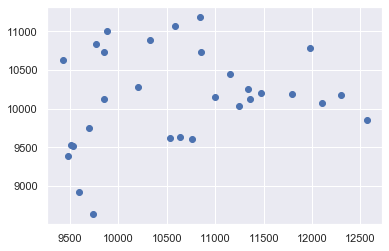

In [23]:
plt.scatter(Y_test, predictions)

In [15]:
df = pd.read_csv('history.csv')
df['time'] = df['time'].apply(lambda x: x[:10])
df.set_index('time',inplace=True)

coin = 'XRP'
df = df[df['coin'] == coin]
df = df[df.columns[1:]]
df = df[df['close']!=0]

df['Date'] = pd.to_datetime(df.index)

,RMSE,Accuracy
July-2019,0.047302,0.888811
June-2019,0.054474,0.903438
May-2019,0.107687,0.821431


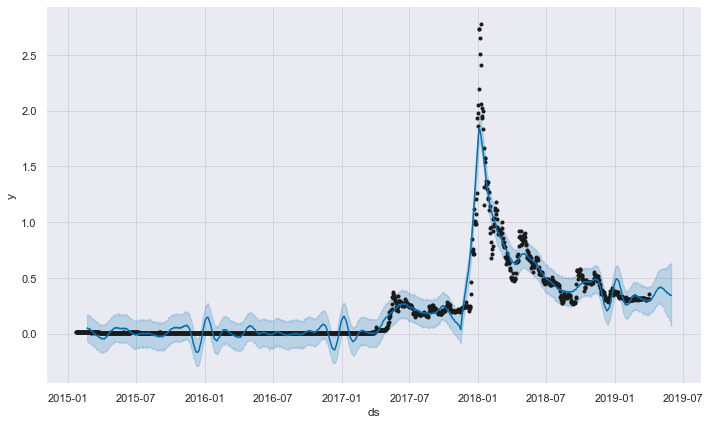

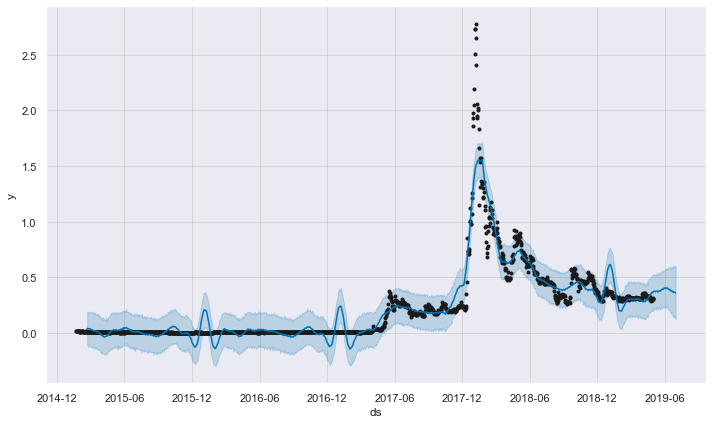

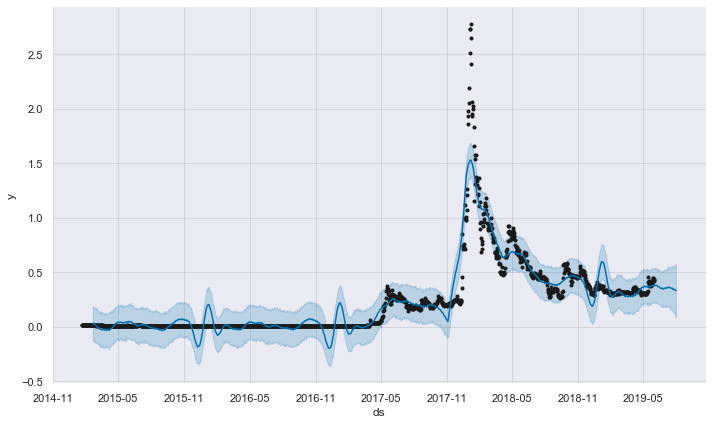

In [18]:
days = 30
t = [90,60,30]
final = pd.DataFrame()
for te in t:
    data = df[['close','Date']][:-te]
    train = data[:-days]
    test = data[-days:]
    train.columns = ['y','ds']
    test.columns = ['y','ds']

    model = Prophet(changepoint_prior_scale=0.5,n_changepoints=25, daily_seasonality=True).fit(train)

    data_forecast = data['Date'] + pd.Timedelta(30, unit='days')
    data_forecast = pd.DataFrame(data_forecast)
    data_forecast.columns = ['ds']
    forecast = model.predict(data_forecast)
    model.plot(forecast);
    
    
    
    normed_train_data = forecast.iloc[:-30,1:]
    Y_train = data['close'][30:]
    normed_test_data = forecast.iloc[-30:,1:]
    if te == 30:
        Y_test = df['close'][-te:]
    else:
        Y_test = df['close'][-te:(-te+30)]

    model = Sequential()
    model.add(Dense(100, input_dim=normed_train_data.shape[1], activation='relu'))
    model.add(LeakyReLU(alpha=0.1))
    #model.add(Dense(20, activation='relu'))
    #model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=adam, metrics=[root_mean_squared_error])
    model.fit(normed_train_data, Y_train, epochs=50, verbose=0,shuffle=False)
    predictions = model.predict(normed_test_data)
    rmse = np.sqrt(metrics.mean_squared_error(Y_test, predictions))
    y = pd.DataFrame()
    y['True'] = Y_test
    y['Predictions'] = predictions
    #y['Score'] = y['True'] / y['Predictions']
    #y['Score'][y['Score'] > 1] = 2 - y['Score'][y['Score'] > 1]
    y['RMSE'] = rmse
    y['t'] = te
    final = pd.concat([final,y])
    
score = []
for i in range(len(final)):
    if final['True'][i] > final['Predictions'][i]:
        score.append(final['Predictions'][i] / final['True'][i])
    else:
        score.append(final['True'][i] / final['Predictions'][i])
final['Score'] = score
res = final['RMSE'].groupby([final['t']]).mean()
res.index = pd.Series(['July','June','May']) + '-2019'
res = pd.DataFrame(res)
res['Accuracy'] = final['Score'].groupby([final['t']]).mean().values
res

In [19]:
final[['True','Predictions','Score']]

,True,Predictions,Score
time,,,
2019-05-03,0.307500,0.506650,0.606928
2019-05-04,0.304800,0.515260,0.591546
2019-05-05,0.300900,0.501215,0.600341
2019-05-06,0.303900,0.473214,0.642204
2019-05-07,0.297500,0.452122,0.658009
2019-05-08,0.300200,0.457401,0.656316
2019-05-09,0.294800,0.468535,0.629196
2019-05-10,0.298400,0.473022,0.630837
2019-05-11,0.321600,0.462344,0.695586


In [33]:
df = pd.read_csv('history.csv')
df['time'] = df['time'].apply(lambda x: x[:10])
df.set_index('time',inplace=True)

coin = 'EOS'
df = df[df['coin'] == coin]
df = df[df.columns[1:]]
df = df[df['close']!=0]

df['Date'] = pd.to_datetime(df.index)

In [34]:
days = 30
t = [30,60,90]
final = pd.DataFrame()
for te in t:
    data = df[['close','Date']][:-te]
    train = data[:-days]
    test = data[-days:]
    train.columns = ['y','ds']
    test.columns = ['y','ds']

    model = Prophet(changepoint_prior_scale=0.5,n_changepoints=25, daily_seasonality=True).fit(train)

    data_forecast = data['Date'] + pd.Timedelta(30, unit='days')
    data_forecast = pd.DataFrame(data_forecast)
    data_forecast.columns = ['ds']
    forecast = model.predict(data_forecast)
    #model.plot(forecast);
    
    
    
    normed_train_data = forecast.iloc[:-30,1:]
    Y_train = data['close'][30:]
    normed_test_data = forecast.iloc[-30:,1:]
    if te == 30:
        Y_test = df['close'][-te:]
    else:
        Y_test = df['close'][-te:(-te+30)]

    model = Sequential()
    model.add(Dense(100, input_dim=normed_train_data.shape[1], activation='relu'))
    model.add(LeakyReLU(alpha=0.1))
    #model.add(Dense(20, activation='relu'))
    #model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=adam, metrics=[root_mean_squared_error])
    model.fit(normed_train_data, Y_train, epochs=50, verbose=0,shuffle=False)
    predictions = model.predict(normed_test_data)
    rmse = np.sqrt(metrics.mean_squared_error(Y_test, predictions))
    y = pd.DataFrame()
    y['True'] = Y_test
    y['Predictions'] = predictions
    #y['Score'] = y['True'] / y['Predictions']
    #y['Score'][y['Score'] > 1] = 2 - y['Score'][y['Score'] > 1]
    y['RMSE'] = rmse
    y['t'] = te
    final = pd.concat([final,y])
    
score = []
for i in range(len(final)):
    if final['True'][i] > final['Predictions'][i]:
        score.append(final['Predictions'][i] / final['True'][i])
    else:
        score.append(final['True'][i] / final['Predictions'][i])
final['Score'] = score
res = final['RMSE'].groupby([final['t']]).mean()
res.index = pd.Series(['July','June','May']) + '-2019'
res = pd.DataFrame(res)
res['Accuracy'] = final['Score'].groupby([final['t']]).mean().values
res

I0809 20:32:11.006825    32 forecaster.py:886] Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
I0809 20:32:16.559557    32 forecaster.py:886] Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
I0809 20:32:22.446777    32 forecaster.py:886] Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,RMSE,Accuracy
July-2019,3.218267,0.609793
June-2019,3.169430,0.711436
May-2019,0.764048,0.908178


In [31]:
vendenkys india ltd , b-1490,t-1520,s-1445    sunpharma 419,414

-7.535227008206434

In [1]:
risk free rate

SyntaxError: invalid syntax (<ipython-input-1-1c77d4c3b6f2>, line 1)

In [1]:
from bs4 import BeautifulSoup
import requests
url = "https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield"
response = requests.get(url)
soup = BeautifulSoup(response.content)

tag = soup.findAll('td', {'class': 'text_view_data'})

tag[-10].text

IndexError: list index out of range

In [9]:
import urllib.request

fp = urllib.request.urlopen(url)
mybytes = fp.read()

mystr = mybytes.decode("utf8")

In [4]:
import urllib

In [5]:
urllib.request.contextlib.

TypeError: 'module' object is not callable

In [27]:
list(-1.94)

TypeError: 'float' object is not iterable

In [28]:
x = -1.94

In [31]:
list([x])*2

[-1.94, -1.94]

In [21]:
from bs4 import BeautifulSoup
import requests
url = "https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield"
response = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})
soup = BeautifulSoup(response.content)
#table = soup("tr", {'class' : 'index_table_in' })


In [23]:
tag = soup.findAll('td', {'class': 'text_view_data'})
tag

[<td class="text_view_data" scope="row">08/01/19</td>,
 <td class="text_view_data">2.11</td>,
 <td class="text_view_data">2.14</td>,
 <td class="text_view_data">2.07</td>,
 <td class="text_view_data">2.04</td>,
 <td class="text_view_data">1.88</td>,
 <td class="text_view_data">1.73</td>,
 <td class="text_view_data">1.67</td>,
 <td class="text_view_data">1.68</td>,
 <td class="text_view_data">1.77</td>,
 <td class="text_view_data">1.90</td>,
 <td class="text_view_data">2.21</td>,
 <td class="text_view_data">2.44</td>,
 <td class="text_view_data" scope="row">08/02/19</td>,
 <td class="text_view_data">2.11</td>,
 <td class="text_view_data">2.12</td>,
 <td class="text_view_data">2.06</td>,
 <td class="text_view_data">2.02</td>,
 <td class="text_view_data">1.85</td>,
 <td class="text_view_data">1.72</td>,
 <td class="text_view_data">1.67</td>,
 <td class="text_view_data">1.66</td>,
 <td class="text_view_data">1.75</td>,
 <td class="text_view_data">1.86</td>,
 <td class="text_view_data">2.16

In [8]:
print(response.text)


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN"
"http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
<html xmlns:o="urn:schemas-microsoft-com:office:office" lang="en-us" dir="ltr">
<head><meta name="GENERATOR" content="Microsoft SharePoint" /><meta name="progid" content="SharePoint.WebPartPage.Document" /><meta http-equiv="Content-Type" content="text/html; charset=utf-8" /><meta http-equiv="Expires" content="0" /><meta name="ROBOTS" content="NOHTMLINDEX" /><title>
	
	Error

</title><link rel="stylesheet" type="text/css" href="/_layouts/1033/styles/Themable/corev4.css?rev=p63%2BuzTeSJc22nVGNZ5zwg%3D%3D"/>
<link rel="stylesheet" type="text/css" href="/Style%20Library/jquery-ui-1.8.6.custom/css/ui-lightness/jquery-ui-exit.css"/>
<link rel="stylesheet" type="text/css" href="/Style%20Library/custom/webEditing.css"/>
<link rel="stylesheet" type="text/css" href="/Style%20Library/custom/treasfor.css"/>
<link rel="stylesheet" type="text/css" href="/Style%20Library/custom/styles.css"/>

In [16]:
link = "https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield"
f = requests.get(link)

In [9]:
soup = BeautifulSoup(f.text)

In [13]:
tag = soup.findAll('td')

In [15]:
tag

[<td class="setTableContentCellWidth">
 <div>
 <p>No feed specified</p>
 </div>
 <br/>
 <!--
 -->
 </td>,
 <td valign="top"><div allowdelete="false" class="ms-WPBody" haspers="true" id="WebPartWPQ2" onlyformepart="true" style="" webpartid="00000000-0000-0000-0000-000000000000" width="100%"><div id="ctl00_PlaceHolderRightRailBakedIn_g_3412dfe2_f44e_40b0_82c4_9c9f313b50aa">
 <div class="t-rr-wrapper">
 <div class="header">
 <h3>Related Offices</h3>
 </div>
 <div class="content">
 <ul>
 <li>
 <a href="/about/organizational-structure/offices/Pages/redirect.aspx?TermId=0a17b84b-4325-4461-af69-a283df4ce14e" title="Debt Management">Debt Management</a>
 </li>
 </ul>
 </div>
 </div>
 <!--[if gte mso 9]><xml>
 <mso:CustomDocumentProperties>
 <mso:AsOfDate msdt:dt="string"></mso:AsOfDate>
 <mso:DisplayAsOfDate msdt:dt="string"></mso:DisplayAsOfDate>
 <mso:display_urn_x003a_schemas-microsoft-com_x003a_office_x003a_office_x0023_Editor msdt:dt="string">System Account</mso:display_urn_x003a_schemas-m

In [7]:
urllib.request()

In [5]:
!pip install beautifulsoup4

In [ ]:
BeautifulSoup()